In [2]:
%pip install -r requirements.txt

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/5f/9e/dce41d5ec9e79add65faf4381d8d4492247b29daaa6cc7d7fd0298abc1e2/shap-0.46.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/9a/51/a4dc2c01ce7a850b8e56ff6d5381d047a5daea83d12bad08aa071d34b2ee/numba-0.60.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/48/41/e1d85ca3cab0b674e277c8c4f678cf66a91cd2cecf93df94353a606fe0db/cloudpickle-3.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.44,>=0.43.0dev0 from https://files.pythonhosted.org/packages/ee/e1/38deed89ced4cf378c61e232265cfe933ccde56ae83c901a

# Modeling

## Import data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from pytorch_tcn import TCN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime
import shap

/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/cleaned_data.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (121625, 25)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False


In [4]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0


## Preprocessing

In [5]:
# Extract time features
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter,hour,day_of_week,month
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,3,10
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,6,3,10
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,3,10
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,2,10
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,2,10


In [34]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'year_month',
       'cluster', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'hour', 'day_of_week', 'month'],
      dtype='object')

In [6]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage',
       'PRCP', 'hour', 'day_of_week', 'month']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lost {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lost 1.61% of data by removing NA


In [7]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Old:

RF

rf = RandomForestRegressor(
    n_estimators=190,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=3,      # Minimum samples required to split a node
    min_samples_leaf=3,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

Best score: 23.469028992220643

XGBoost
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
Best mse: 22.214858875924424

TCN
num_channels = [16, 32, 64, 128]  # Number of filters in each layer
kernel_size = 5
dropout = 0.3
model = HybridTCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best KNN Test MSE: 29.4558

# Random Forest

In [38]:
param_grid = {
    'n_estimators': [_ for _ in range(150, 251, 25)],
    'max_depth': [_ for _ in range(10, 21)],
    'min_samples_split': [_ for _ in range(2, 5)],
    'min_samples_leaf': [_ for _ in range(2, 5)]
}

# min_samples_split=3, min_samples_leaf=3, n_estimators=190
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                    n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print best parameters and score from grid search
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

# Get the best estimator
rf = grid.best_estimator_

/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250}
Best mse: 16.04237449579302


In [8]:
rf = RandomForestRegressor(
    n_estimators=250,         # Number of trees in the forest
    max_depth=20,             # Maximum depth of each tree
    min_samples_split=4,      # Minimum samples required to split a node
    min_samples_leaf=2,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

# Step 2: Fit the model
rf.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf.predict(X_test)

# Step 4: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16.145287846800496
Mean Absolute Error: 2.5098619588374076
R^2 Score: 0.6182386890929961


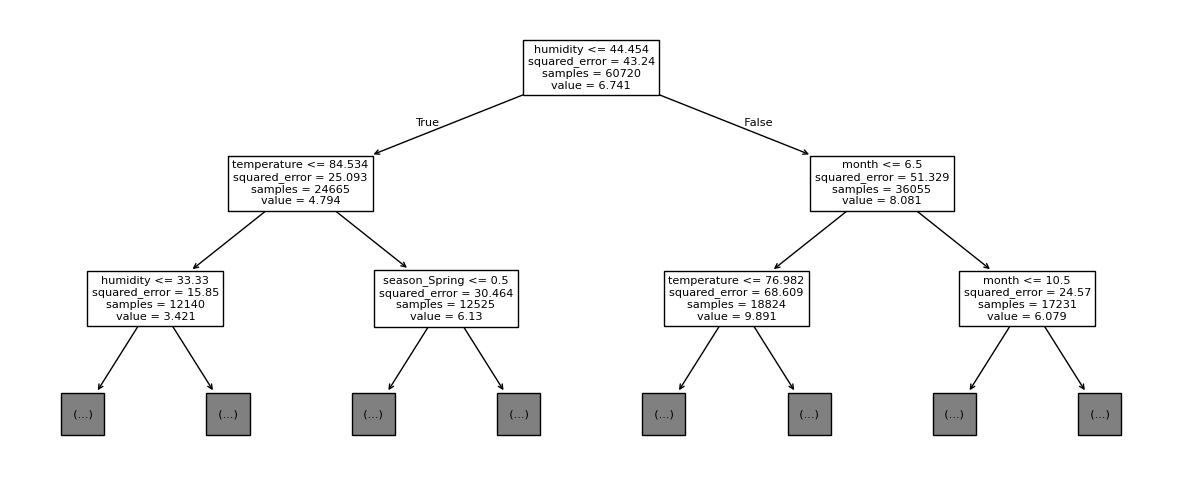

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 6))
tree_index = np.random.randint(0, 251, size=1).item()
plot_tree(rf.estimators_[tree_index], feature_names=X_train.columns, max_depth=2)
plt.show()

# XGBoost

In [46]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [11, 12, 13], # 12
    'learning_rate': [0.02, 0.03, 0.04], # 0.03
    'n_estimators': [700, 750, 800], # 600
    'subsample': [0.85, 0.9], # 0.9
    'colsample_bytree': [0.85, 0.9] # 0.8
}

# Initialize the XGBoost regressor
xgb_ = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# CV
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)

grid.fit(X_train, y_train)

# Display results
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
Best mse: 12.872662893439998


In [11]:
# Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
# Best mse: 12.872662893439998
best_params = {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
best_xgb = xgb.XGBRegressor(**best_params)

best_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Squared Error: {mae_xgb}")
print(f"R^2 Score: {r2_xgb}")

Mean Squared Error: 12.958447287233257
Mean Squared Error: 2.1336655804320874
R^2 Score: 0.6935927144418284


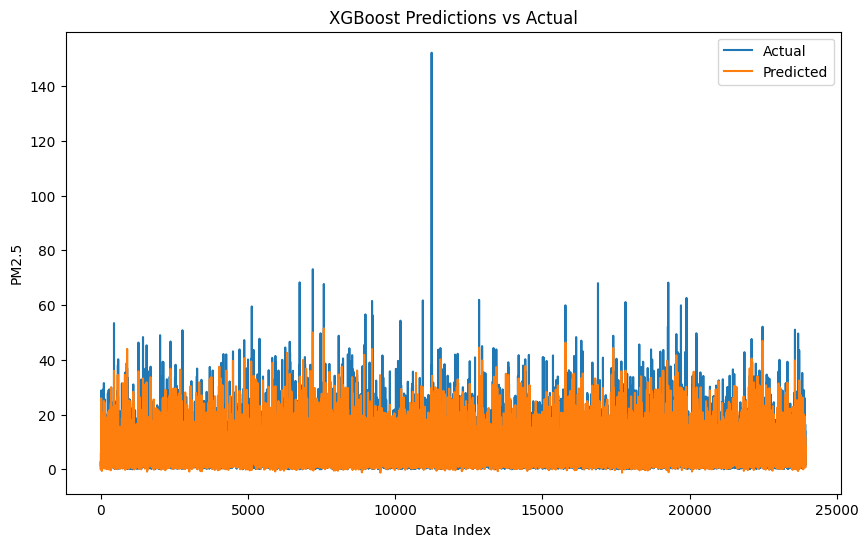

In [85]:
# Plot the predictions from XGBoost against the testing data
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_xgb, label='Predicted')
plt.xlabel('Data Index')
plt.ylabel('PM2.5')
plt.title('XGBoost Predictions vs Actual')
plt.legend()
plt.show()


# Neural Network

In [64]:
'''
Old, from attention
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
'''

Training TCN:   1%|          | 1/100 [02:40<4:25:13, 160.74s/it]

Epoch 1/100 | Train Loss: 31.8439 | Test Loss: 28.9218


Training TCN:   2%|▏         | 2/100 [05:20<4:21:26, 160.07s/it]

Epoch 2/100 | Train Loss: 28.4165 | Test Loss: 28.2275


Training TCN:   3%|▎         | 3/100 [08:00<4:18:48, 160.08s/it]

Epoch 3/100 | Train Loss: 26.5646 | Test Loss: 26.3812


Training TCN:   4%|▍         | 4/100 [10:45<4:19:19, 162.08s/it]

Epoch 4/100 | Train Loss: 25.3914 | Test Loss: 25.1808


Training TCN:   5%|▌         | 5/100 [13:31<4:19:01, 163.59s/it]

Epoch 5/100 | Train Loss: 24.3957 | Test Loss: 24.9169


Training TCN:   6%|▌         | 6/100 [16:09<4:13:07, 161.57s/it]

Epoch 6/100 | Train Loss: 23.6923 | Test Loss: 23.7647


Training TCN:   7%|▋         | 7/100 [18:45<4:07:50, 159.90s/it]

Epoch 7/100 | Train Loss: 22.9430 | Test Loss: 23.4000


Training TCN:   8%|▊         | 8/100 [21:22<4:03:21, 158.71s/it]

Epoch 8/100 | Train Loss: 22.3650 | Test Loss: 22.7303


Training TCN:   9%|▉         | 9/100 [24:00<4:00:32, 158.60s/it]

Epoch 9/100 | Train Loss: 21.7019 | Test Loss: 22.7406


Training TCN:  10%|█         | 10/100 [26:40<3:58:25, 158.95s/it]

Epoch 10/100 | Train Loss: 21.1363 | Test Loss: 22.0533


Training TCN:  11%|█         | 11/100 [29:27<3:59:25, 161.41s/it]

Epoch 11/100 | Train Loss: 20.0039 | Test Loss: 20.8435


Training TCN:  12%|█▏        | 12/100 [32:14<3:59:35, 163.35s/it]

Epoch 12/100 | Train Loss: 19.4888 | Test Loss: 20.6498


Training TCN:  13%|█▎        | 13/100 [35:03<3:59:13, 164.99s/it]

Epoch 13/100 | Train Loss: 19.1210 | Test Loss: 20.4788


Training TCN:  14%|█▍        | 14/100 [37:51<3:57:43, 165.86s/it]

Epoch 14/100 | Train Loss: 18.6996 | Test Loss: 19.8088


Training TCN:  15%|█▌        | 15/100 [40:38<3:55:33, 166.27s/it]

Epoch 15/100 | Train Loss: 18.4591 | Test Loss: 19.9421


Training TCN:  16%|█▌        | 16/100 [43:28<3:54:16, 167.34s/it]

Epoch 16/100 | Train Loss: 18.0609 | Test Loss: 19.3311


Training TCN:  17%|█▋        | 17/100 [46:17<3:52:07, 167.80s/it]

Epoch 17/100 | Train Loss: 17.7940 | Test Loss: 18.8125


Training TCN:  18%|█▊        | 18/100 [49:06<3:49:53, 168.21s/it]

Epoch 18/100 | Train Loss: 17.4588 | Test Loss: 18.7005


Training TCN:  19%|█▉        | 19/100 [51:51<3:45:39, 167.16s/it]

Epoch 19/100 | Train Loss: 17.2132 | Test Loss: 18.3689


Training TCN:  20%|██        | 20/100 [54:38<3:42:54, 167.18s/it]

Epoch 20/100 | Train Loss: 16.8932 | Test Loss: 18.2991


Training TCN:  21%|██        | 21/100 [57:21<3:38:16, 165.78s/it]

Epoch 21/100 | Train Loss: 15.9999 | Test Loss: 17.7216


Training TCN:  22%|██▏       | 22/100 [1:00:00<3:33:05, 163.91s/it]

Epoch 22/100 | Train Loss: 15.7902 | Test Loss: 17.5602


Training TCN:  23%|██▎       | 23/100 [1:02:38<3:27:54, 162.00s/it]

Epoch 23/100 | Train Loss: 15.6380 | Test Loss: 17.5509


Training TCN:  24%|██▍       | 24/100 [1:05:14<3:22:59, 160.26s/it]

Epoch 24/100 | Train Loss: 15.3826 | Test Loss: 17.3194


Training TCN:  25%|██▌       | 25/100 [1:07:50<3:18:45, 159.01s/it]

Epoch 25/100 | Train Loss: 15.2322 | Test Loss: 17.2238


Training TCN:  26%|██▌       | 26/100 [1:10:25<3:14:44, 157.90s/it]

Epoch 26/100 | Train Loss: 15.1341 | Test Loss: 16.9876


Training TCN:  27%|██▋       | 27/100 [1:13:01<3:11:15, 157.20s/it]

Epoch 27/100 | Train Loss: 15.0011 | Test Loss: 16.9338


Training TCN:  28%|██▊       | 28/100 [1:15:37<3:08:16, 156.90s/it]

Epoch 28/100 | Train Loss: 14.8149 | Test Loss: 16.9791


Training TCN:  29%|██▉       | 29/100 [1:18:14<3:05:35, 156.84s/it]

Epoch 29/100 | Train Loss: 14.7220 | Test Loss: 17.1756


Training TCN:  30%|███       | 30/100 [1:20:50<3:02:43, 156.62s/it]

Epoch 30/100 | Train Loss: 14.5173 | Test Loss: 16.7375


Training TCN:  31%|███       | 31/100 [1:23:28<3:00:30, 156.97s/it]

Epoch 31/100 | Train Loss: 14.0228 | Test Loss: 16.5640


Training TCN:  32%|███▏      | 32/100 [1:26:07<2:58:34, 157.56s/it]

Epoch 32/100 | Train Loss: 13.8754 | Test Loss: 16.5365


Training TCN:  33%|███▎      | 33/100 [1:28:45<2:56:18, 157.89s/it]

Epoch 33/100 | Train Loss: 13.8192 | Test Loss: 16.4678


Training TCN:  34%|███▍      | 34/100 [1:31:32<2:56:44, 160.67s/it]

Epoch 34/100 | Train Loss: 13.6248 | Test Loss: 16.2524


Training TCN:  35%|███▌      | 35/100 [1:34:11<2:53:27, 160.12s/it]

Epoch 35/100 | Train Loss: 13.6585 | Test Loss: 16.1915


Training TCN:  36%|███▌      | 36/100 [1:36:48<2:49:40, 159.07s/it]

Epoch 36/100 | Train Loss: 13.5178 | Test Loss: 16.1706


Training TCN:  37%|███▋      | 37/100 [1:39:24<2:46:07, 158.21s/it]

Epoch 37/100 | Train Loss: 13.4356 | Test Loss: 16.1479


Training TCN:  38%|███▊      | 38/100 [1:42:01<2:42:59, 157.73s/it]

Epoch 38/100 | Train Loss: 13.4121 | Test Loss: 16.2067


Training TCN:  39%|███▉      | 39/100 [1:44:37<2:39:52, 157.25s/it]

Epoch 39/100 | Train Loss: 13.2470 | Test Loss: 16.1457


Training TCN:  40%|████      | 40/100 [1:47:15<2:37:35, 157.59s/it]

Epoch 40/100 | Train Loss: 13.2877 | Test Loss: 16.0957


Training TCN:  41%|████      | 41/100 [1:49:55<2:35:30, 158.14s/it]

Epoch 41/100 | Train Loss: 12.9053 | Test Loss: 15.9518


Training TCN:  42%|████▏     | 42/100 [1:52:35<2:33:38, 158.95s/it]

Epoch 42/100 | Train Loss: 12.8651 | Test Loss: 15.8854


Training TCN:  43%|████▎     | 43/100 [1:57:52<3:15:50, 206.16s/it]

Epoch 43/100 | Train Loss: 12.8689 | Test Loss: 15.8905


Training TCN:  44%|████▍     | 44/100 [2:03:19<3:46:23, 242.56s/it]

Epoch 44/100 | Train Loss: 12.7362 | Test Loss: 15.8689


Training TCN:  45%|████▌     | 45/100 [2:08:37<4:02:54, 264.99s/it]

Epoch 45/100 | Train Loss: 12.7195 | Test Loss: 15.7540


Training TCN:  46%|████▌     | 46/100 [2:14:03<4:15:04, 283.42s/it]

Epoch 46/100 | Train Loss: 12.7112 | Test Loss: 15.9690


Training TCN:  47%|████▋     | 47/100 [2:19:18<4:18:50, 293.02s/it]

Epoch 47/100 | Train Loss: 12.6478 | Test Loss: 15.7665


Training TCN:  48%|████▊     | 48/100 [2:24:33<4:19:32, 299.48s/it]

Epoch 48/100 | Train Loss: 12.6293 | Test Loss: 15.6926


Training TCN:  49%|████▉     | 49/100 [2:29:50<4:19:02, 304.75s/it]

Epoch 49/100 | Train Loss: 12.5659 | Test Loss: 15.6642


Training TCN:  50%|█████     | 50/100 [2:35:03<4:15:56, 307.13s/it]

Epoch 50/100 | Train Loss: 12.5208 | Test Loss: 15.7929


Training TCN:  51%|█████     | 51/100 [2:40:16<4:12:26, 309.11s/it]

Epoch 51/100 | Train Loss: 12.3573 | Test Loss: 15.7140


Training TCN:  52%|█████▏    | 52/100 [2:45:29<4:08:12, 310.26s/it]

Epoch 52/100 | Train Loss: 12.3725 | Test Loss: 15.7028


Training TCN:  53%|█████▎    | 53/100 [2:50:51<4:05:44, 313.71s/it]

Epoch 53/100 | Train Loss: 12.3011 | Test Loss: 15.6366


Training TCN:  54%|█████▍    | 54/100 [2:56:18<4:03:29, 317.59s/it]

Epoch 54/100 | Train Loss: 12.3386 | Test Loss: 15.5926


Training TCN:  55%|█████▌    | 55/100 [3:01:44<4:00:10, 320.24s/it]

Epoch 55/100 | Train Loss: 12.2933 | Test Loss: 15.6111


Training TCN:  56%|█████▌    | 56/100 [3:07:14<3:57:01, 323.21s/it]

Epoch 56/100 | Train Loss: 12.2559 | Test Loss: 15.5647


Training TCN:  57%|█████▋    | 57/100 [3:12:44<3:53:02, 325.17s/it]

Epoch 57/100 | Train Loss: 12.2648 | Test Loss: 15.6448


Training TCN:  58%|█████▊    | 58/100 [3:18:13<3:48:28, 326.39s/it]

Epoch 58/100 | Train Loss: 12.2160 | Test Loss: 15.5782


Training TCN:  59%|█████▉    | 59/100 [3:23:43<3:43:37, 327.25s/it]

Epoch 59/100 | Train Loss: 12.1767 | Test Loss: 15.6071


Training TCN:  60%|██████    | 60/100 [3:29:12<3:38:30, 327.77s/it]

Epoch 60/100 | Train Loss: 12.1979 | Test Loss: 15.6062


Training TCN:  61%|██████    | 61/100 [3:34:41<3:33:16, 328.13s/it]

Epoch 61/100 | Train Loss: 12.0692 | Test Loss: 15.6500


Training TCN:  62%|██████▏   | 62/100 [3:40:09<3:27:52, 328.23s/it]

Epoch 62/100 | Train Loss: 12.0391 | Test Loss: 15.4968


Training TCN:  63%|██████▎   | 63/100 [3:45:37<3:22:24, 328.24s/it]

Epoch 63/100 | Train Loss: 12.0713 | Test Loss: 15.5326


Training TCN:  64%|██████▍   | 64/100 [3:51:05<3:16:54, 328.17s/it]

Epoch 64/100 | Train Loss: 12.0936 | Test Loss: 15.5026


Training TCN:  65%|██████▌   | 65/100 [3:56:35<3:11:37, 328.50s/it]

Epoch 65/100 | Train Loss: 12.1063 | Test Loss: 15.4888


Training TCN:  66%|██████▌   | 66/100 [4:02:03<3:06:10, 328.53s/it]

Epoch 66/100 | Train Loss: 12.0328 | Test Loss: 15.5093


Training TCN:  67%|██████▋   | 67/100 [4:07:32<3:00:47, 328.71s/it]

Epoch 67/100 | Train Loss: 12.0075 | Test Loss: 15.5243


Training TCN:  68%|██████▊   | 68/100 [4:13:03<2:55:36, 329.27s/it]

Epoch 68/100 | Train Loss: 12.0571 | Test Loss: 15.5297


Training TCN:  69%|██████▉   | 69/100 [4:18:32<2:50:02, 329.10s/it]

Epoch 69/100 | Train Loss: 12.0406 | Test Loss: 15.4964


Training TCN:  70%|███████   | 70/100 [4:24:00<2:44:27, 328.91s/it]

Epoch 70/100 | Train Loss: 11.9790 | Test Loss: 15.5185


Training TCN:  71%|███████   | 71/100 [4:29:31<2:39:16, 329.53s/it]

Epoch 71/100 | Train Loss: 11.9110 | Test Loss: 15.5142


Training TCN:  72%|███████▏  | 72/100 [4:35:02<2:33:55, 329.82s/it]

Epoch 72/100 | Train Loss: 11.9138 | Test Loss: 15.4616


Training TCN:  73%|███████▎  | 73/100 [4:40:31<2:28:22, 329.73s/it]

Epoch 73/100 | Train Loss: 11.9075 | Test Loss: 15.4750


Training TCN:  74%|███████▍  | 74/100 [4:46:02<2:23:03, 330.13s/it]

Epoch 74/100 | Train Loss: 11.9617 | Test Loss: 15.4897


Training TCN:  75%|███████▌  | 75/100 [4:51:30<2:17:15, 329.42s/it]

Epoch 75/100 | Train Loss: 11.9052 | Test Loss: 15.4821


Training TCN:  76%|███████▌  | 76/100 [4:57:00<2:11:49, 329.55s/it]

Epoch 76/100 | Train Loss: 11.9421 | Test Loss: 15.4511


Training TCN:  77%|███████▋  | 77/100 [5:02:29<2:06:18, 329.51s/it]

Epoch 77/100 | Train Loss: 11.9383 | Test Loss: 15.4600


Training TCN:  78%|███████▊  | 78/100 [5:07:59<2:00:50, 329.59s/it]

Epoch 78/100 | Train Loss: 11.9614 | Test Loss: 15.4775


Training TCN:  79%|███████▉  | 79/100 [5:13:29<1:55:21, 329.61s/it]

Epoch 79/100 | Train Loss: 11.9281 | Test Loss: 15.4897


Training TCN:  80%|████████  | 80/100 [5:19:00<1:50:03, 330.19s/it]

Epoch 80/100 | Train Loss: 11.9172 | Test Loss: 15.5023


Training TCN:  81%|████████  | 81/100 [5:24:32<1:44:41, 330.58s/it]

Epoch 81/100 | Train Loss: 11.9189 | Test Loss: 15.4554


Training TCN:  82%|████████▏ | 82/100 [5:30:00<1:39:00, 330.02s/it]

Epoch 82/100 | Train Loss: 11.8794 | Test Loss: 15.4482


Training TCN:  83%|████████▎ | 83/100 [5:35:40<1:34:19, 332.91s/it]

Epoch 83/100 | Train Loss: 11.8384 | Test Loss: 15.5933


Training TCN:  84%|████████▍ | 84/100 [5:41:07<1:28:20, 331.26s/it]

Epoch 84/100 | Train Loss: 11.8237 | Test Loss: 15.5161


Training TCN:  85%|████████▌ | 85/100 [5:46:36<1:22:35, 330.40s/it]

Epoch 85/100 | Train Loss: 11.8537 | Test Loss: 15.4512


Training TCN:  86%|████████▌ | 86/100 [5:52:06<1:17:05, 330.40s/it]

Epoch 86/100 | Train Loss: 11.9041 | Test Loss: 15.4346


Training TCN:  87%|████████▋ | 87/100 [5:57:34<1:11:23, 329.51s/it]

Epoch 87/100 | Train Loss: 11.8509 | Test Loss: 15.4088


Training TCN:  88%|████████▊ | 88/100 [6:03:01<1:05:46, 328.87s/it]

Epoch 88/100 | Train Loss: 11.8462 | Test Loss: 15.4893


Training TCN:  89%|████████▉ | 89/100 [6:08:31<1:00:22, 329.33s/it]

Epoch 89/100 | Train Loss: 11.8358 | Test Loss: 15.4353


Training TCN:  90%|█████████ | 90/100 [6:14:11<55:23, 332.39s/it]  

Epoch 90/100 | Train Loss: 11.8776 | Test Loss: 15.4225


Training TCN:  91%|█████████ | 91/100 [6:20:07<50:55, 339.54s/it]

Epoch 91/100 | Train Loss: 11.8161 | Test Loss: 15.4283


Training TCN:  92%|█████████▏| 92/100 [6:25:53<45:32, 341.56s/it]

Epoch 92/100 | Train Loss: 11.8513 | Test Loss: 15.4657


Training TCN:  93%|█████████▎| 93/100 [6:31:14<39:05, 335.12s/it]

Epoch 93/100 | Train Loss: 11.8424 | Test Loss: 15.4347


Training TCN:  94%|█████████▍| 94/100 [6:36:43<33:20, 333.36s/it]

Epoch 94/100 | Train Loss: 11.8363 | Test Loss: 15.4575


Training TCN:  95%|█████████▌| 95/100 [6:42:12<27:39, 331.99s/it]

Epoch 95/100 | Train Loss: 11.8331 | Test Loss: 15.5543


Training TCN:  96%|█████████▌| 96/100 [6:48:26<22:58, 344.67s/it]

Epoch 96/100 | Train Loss: 11.8130 | Test Loss: 15.4503


Training TCN:  96%|█████████▌| 96/100 [6:56:43<17:21, 260.45s/it]

Early stopping at epoch 97


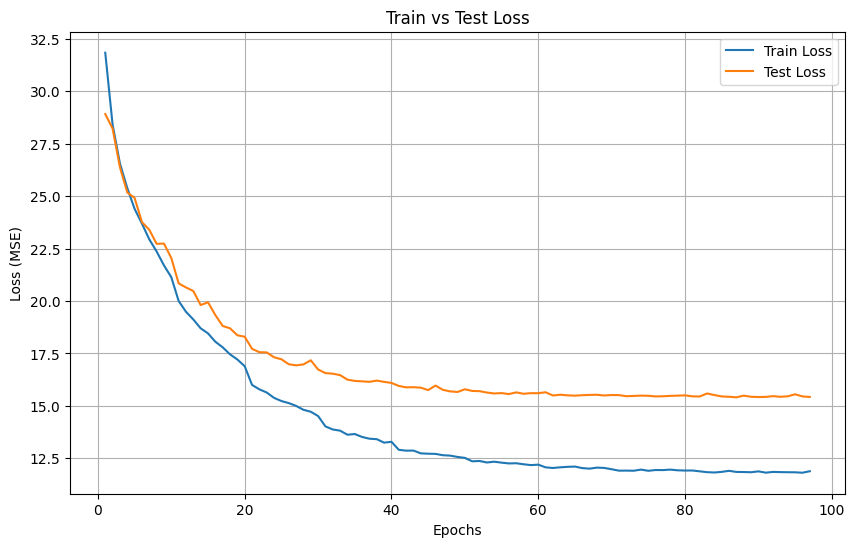

Best model saved at best_tcn_model.pth with Test Loss: 15.4088


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# Temporal Convolutional Network (TCN) Model
# ----------------------------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.batch_norm1 = nn.BatchNorm1d(output_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(output_dim, output_dim, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.batch_norm2 = nn.BatchNorm1d(output_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.batch_norm1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.batch_norm2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(input_dim, output_dim, 1) if input_dim != output_dim else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size, stride=1, 
                              dilation=dilation, padding=(kernel_size-1) * dilation, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        out = self.network(x)
        out = out.mean(dim=2)  # Global average pooling over the sequence
        return self.fc(out)

# ----------------------------
# Data Preparation
# ----------------------------
scaler_x = StandardScaler()

# Fit scalers on training data and transform both train and test data
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Convert scaled data to PyTorch tensors, keeping y values unscaled
train_x = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)  # Add dummy sequence dimension
train_y = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)
test_x = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
test_y = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)

# Create DataLoader for batching
batch_size = 32
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=False)

# ----------------------------
# Model and Training Setup
# ----------------------------
input_size = X_train.shape[1]
output_size = 1  # Single target
num_channels = [64, 128, 256]  # Keep model complexity similar
kernel_size = 5
dropout = 0.3  # Moderate increase in dropout

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()  # Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Light regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ----------------------------
# Training with Early Stopping and Model Saving
# ----------------------------
epochs = 100
patience = 10
min_delta = 1e-4
best_loss = float('inf')
stop_indicator = 0
best_model_path = "best_tcn_model.pth"

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs), desc="Training TCN"):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    # Save best model based on test loss
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        stop_indicator = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        stop_indicator += 1

    if stop_indicator >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# ----------------------------
# Save Train and Test Losses and Plot
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.show()

# Load the best model
print(f"Best model saved at {best_model_path} with Test Loss: {best_loss:.4f}")

In [81]:
# Replace tcn_model with model
model.load_state_dict(torch.load(best_model_path))
# Calculate predictions on the test set
model.eval()

test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        test_predictions.extend(outputs.squeeze().tolist())
        test_targets.extend(batch_y.tolist())

# Convert lists to numpy arrays for metric calculations
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

# Calculate MSE, MAE, and R^2
mse = mean_squared_error(test_targets, test_predictions)
mae = np.mean(np.abs(test_targets - test_predictions))
r2 = 1 - (np.sum((test_targets - test_predictions) ** 2) / np.sum((test_targets - np.mean(test_targets)) ** 2))

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

/var/folders/yk/4g22n5fx1m96780wglc148nh0000gn/T/ipykernel_25917/2775870044.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

MSE: 15.4097
MAE: 2.5014
R^2: 0.6356


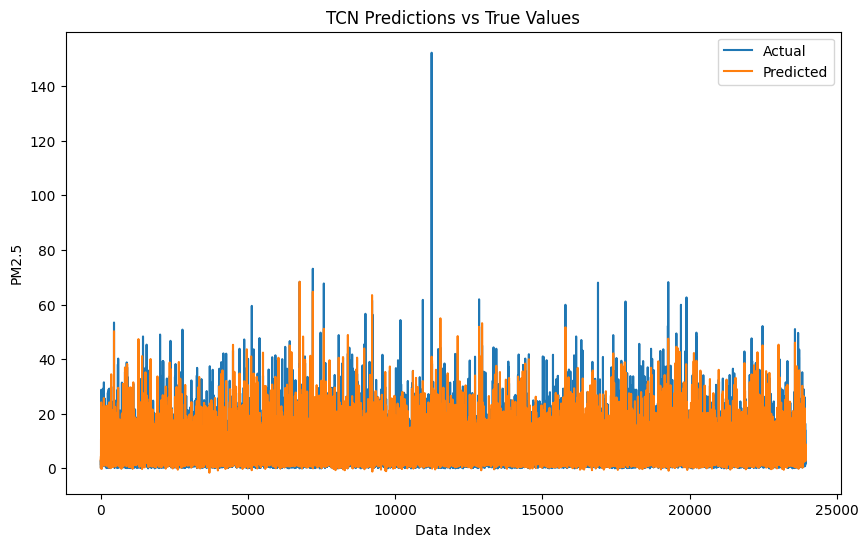

In [89]:
# Plot the TCN predictions vs the data
plt.figure(figsize=(10, 6))
plt.plot(test_targets, label="Actual")
plt.plot(test_predictions, label="Predicted")
plt.xlabel("Data Index")
plt.ylabel("PM2.5")
plt.title("TCN Predictions vs True Values")
plt.legend()
plt.show()

# Bayesian Neural Network

In [139]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# Bayesian Neural Network Model with Increased Complexity
# ----------------------------
class BayesianNN(PyroModule):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, hidden_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](hidden_dim, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 0.75).expand([1, hidden_dim]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 0.75).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc3(x).squeeze(-1)
        sigma = pyro.sample("sigma", dist.HalfNormal(1.0))  # More flexible noise variance
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# ----------------------------
# Prepare Data with Feature Scaling
# ----------------------------
scaler_x = StandardScaler()

# Fit scalers on training data and transform both train and test data
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Convert scaled data to PyTorch tensors, preserving original y values
train_x = torch.tensor(X_train_scaled, dtype=torch.float32)
train_y = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)
test_x = torch.tensor(X_test_scaled, dtype=torch.float32)
test_y = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)

# Create DataLoader for batching
batch_size = 16
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)

# ----------------------------
# Training Setup with Reduced Regularization and Scheduler
# ----------------------------
input_dim = train_x.shape[1]
hidden_dim = 200  # Increased hidden dimension
model = BayesianNN(input_dim, hidden_dim)

# Define the guide
def guide(x, y=None):
    for name, module in model.named_modules():
        for param_name, param in module.named_parameters(recurse=False):
            full_name = f"{name}.{param_name}" if name else param_name
            if isinstance(param, PyroSample):
                pyro.sample(full_name, dist.Normal(
                    loc=pyro.param(f"{full_name}_loc", torch.randn_like(param)),
                    scale=pyro.param(f"{full_name}_scale", torch.ones_like(param), constraint=dist.constraints.positive)
                ))
    pyro.sample("sigma", dist.Normal(
        loc=pyro.param("sigma_loc", torch.tensor(1.0)),
        scale=pyro.param("sigma_scale", torch.tensor(0.1), constraint=dist.constraints.positive)
    ))

# Define optimizer and SVI with reduced regularization (KL term)
optimizer = Adam({"lr": 1e-5, "weight_decay": 1e-5})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1, tail_adaptive_beta=0.5))  # Reduce KL weight

# ----------------------------
# Train the Model with MSE Tracking
# ----------------------------
epochs = 100
train_losses = []  # ELBO train losses
test_losses = []   # ELBO test losses
train_mse_list = []  # Train MSE
test_mse_list = []   # Test MSE

for epoch in tqdm(range(epochs), desc="Training BNN"):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        loss = svi.step(batch_x, batch_y)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping
        epoch_loss += loss

    # Calculate average train loss (ELBO)
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate train and test losses
    model.eval()
    with torch.no_grad():
        # Train MSE
        predictive_train = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=("obs",))
        train_predictions = predictive_train(train_x)
        train_pred_means = train_predictions["obs"].mean(0)
        train_mse = mean_squared_error(train_y.numpy(), train_pred_means.numpy())
        train_mse_list.append(train_mse)

        # Test MSE
        predictive_test = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=("obs",))
        test_predictions = predictive_test(test_x)
        test_pred_means = test_predictions["obs"].mean(0)
        test_loss = torch.mean((test_pred_means - test_y) ** 2).item()
        test_losses.append(test_loss)
        test_mse = mean_squared_error(test_y.numpy(), test_pred_means.numpy())
        test_mse_list.append(test_mse)

    print(
        f"Epoch {epoch + 1}/{epochs} | Train Loss (ELBO): {avg_train_loss:.4f} | "
        f"Test Loss (ELBO): {test_loss:.4f} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}"
    )

# ----------------------------
# Plot Train vs Test Loss and MSE
# ----------------------------
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss (ELBO)")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss (ELBO)")
plt.plot(range(1, epochs + 1), train_mse_list, label="Train MSE")
plt.plot(range(1, epochs + 1), test_mse_list, label="Test MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss and MSE Over Epochs")
plt.legend()
plt.grid()
plt.show()

Training BNN:   1%|          | 1/100 [01:40<2:45:17, 100.18s/it]

Epoch 1/100 | Train Loss (ELBO): 51059.0900 | Test Loss (ELBO): 87.2311 | Train MSE: 88.2798 | Test MSE: 87.2311


Training BNN:   2%|▏         | 2/100 [03:21<2:44:53, 100.95s/it]

Epoch 2/100 | Train Loss (ELBO): 51043.0590 | Test Loss (ELBO): 121.0359 | Train MSE: 153.4687 | Test MSE: 121.0359


Training BNN:   3%|▎         | 3/100 [05:02<2:43:07, 100.90s/it]

Epoch 3/100 | Train Loss (ELBO): 51056.9143 | Test Loss (ELBO): 77.6630 | Train MSE: 275.8461 | Test MSE: 77.6630


Training BNN:   3%|▎         | 3/100 [06:08<3:18:19, 122.67s/it]


KeyboardInterrupt: 

In [53]:
mse_bnn = mean_squared_error(y_test, pred_means_original)
print(f"BNN Test MSE: {mse_bnn:.4f}")

BNN Test MSE: 47.7514


# KNN

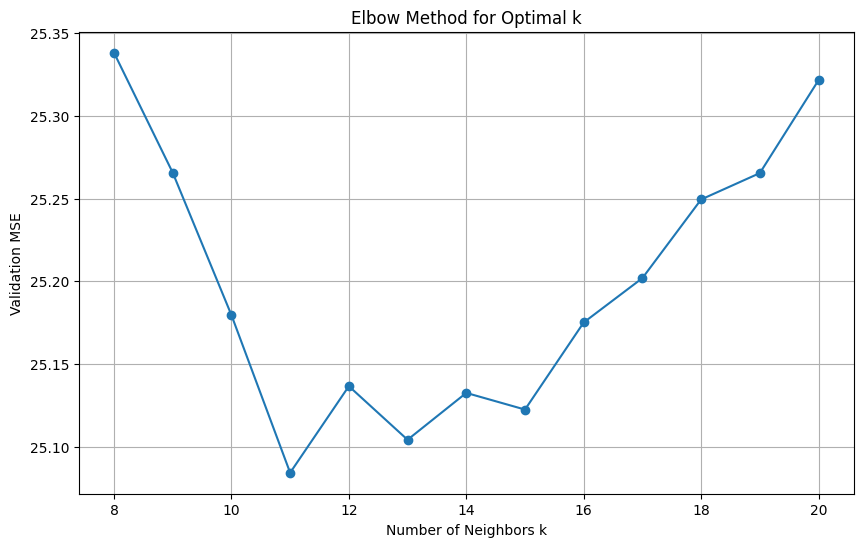

Optimal number of neighbors (k) found: 11
Best KNN Test MSE: 27.4941
Best KNN Test MAE: 3.3065
Best KNN r^2 score: 0.3644


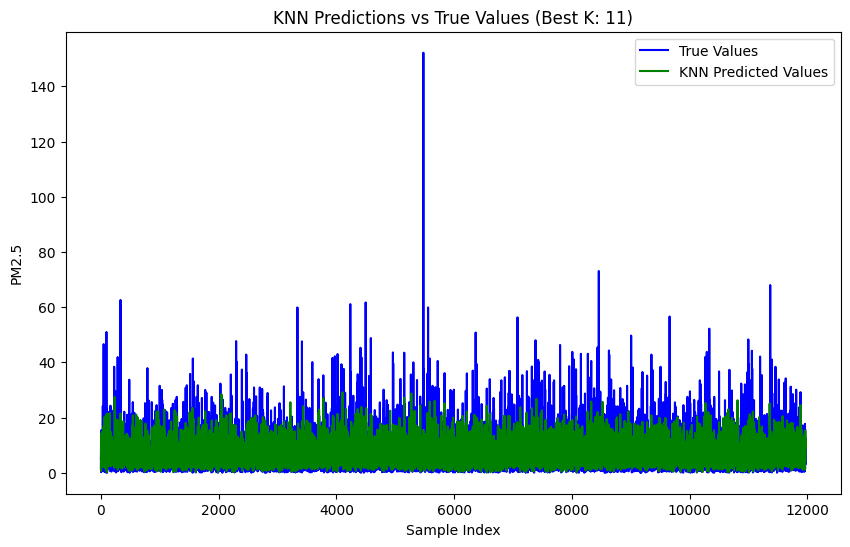

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Split the test data into a validation set and a new test set
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_new)

# Use the elbow method to find the optimal number of neighbors
mse_values = []
k_range = range(8, 21)  # Test values of K from 8 to 20

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled, y_train)
    y_val_pred = knn.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_val_pred)
    mse_values.append(mse)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, mse_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Validation MSE')
plt.grid()
plt.show()

# Choose the best k (where the elbow occurs)
best_k = k_range[mse_values.index(min(mse_values))]
print(f"Optimal number of neighbors (k) found: {best_k}")

# Train the KNN model with the best k
best_knn = KNeighborsRegressor(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Predict on the new test set using the best KNN model
y_pred_knn = best_knn.predict(X_test_scaled)

# Calculate the MSE, MAE, and R^2 for the best KNN model
mse_knn = mean_squared_error(y_test_new, y_pred_knn)
mae_knn = mean_absolute_error(y_test_new, y_pred_knn)
r2_knn = r2_score(y_test_new, y_pred_knn)
print(f"Best KNN Test MSE: {mse_knn:.4f}")
print(f"Best KNN Test MAE: {mae_knn:.4f}")
print(f"Best KNN r^2 score: {r2_knn:.4f}")

# Plot the true values vs the KNN predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_new.to_numpy(), label="True Values", color="blue")
plt.plot(y_pred_knn, label="KNN Predicted Values", color="green")
plt.legend()
plt.title(f"KNN Predictions vs True Values (Best K: {best_k})")
plt.xlabel("Sample Index")
plt.ylabel("PM2.5")
plt.show()

# Interpretability

In [9]:
import matplotlib.pyplot as plt

plt.ioff()

## Residual Plot

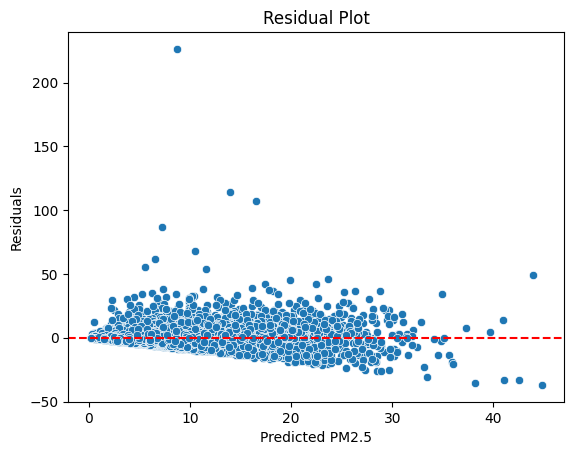

In [15]:
import seaborn as sns

y_pred = rf.predict(X_test)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## PDP

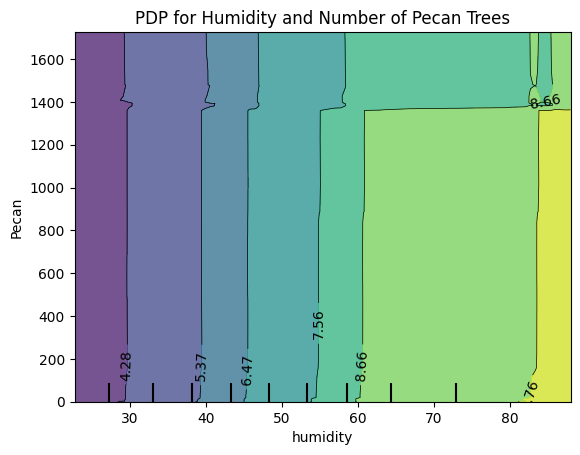

In [13]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# features_PDP = ['humidity']
features_PDP = [('humidity', 'Pecan')]

PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='average')
plt.title('PDP for Humidity and Number of Pecan Trees')
plt.show()

In [32]:
for f in features:
    PartialDependenceDisplay.from_estimator(rf_regressor, X, [f], kind='average')
    name = f.lower().replace(' ', '_')
    title_case = f.replace('_', ' ').replace('PRCP', 'Precipitation').title()
    plt.title(f'PDP for {title_case}')
    plt.xlabel(title_case)
    plt.savefig(f'./plots/pdp_{name}', dpi=300, bbox_inches='tight')
    plt.close()

## ICE

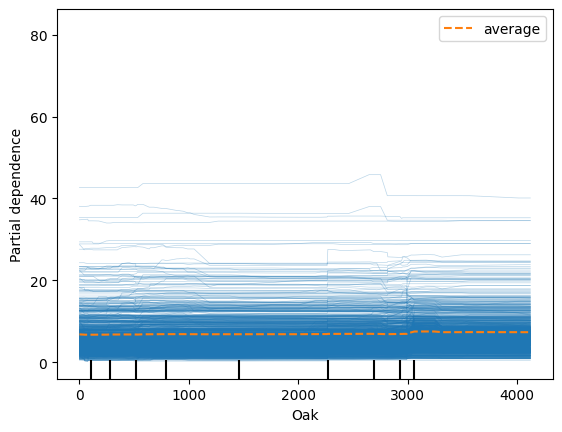

In [13]:
# Takes a long time to run
PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='both')
plt.title('ICE plot')
plt.show()

## ALE

In [ ]:
from PyALE import ale

ale_eff = ale(X=X, model=rf_regressor, feature=features_PDP, grid_size=50, include_CI=False)
plt.title('ALE plot')
plt.show()

## SHAP

In [21]:
import shap

explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer(X_train.sample(n=5000, random_state=42))

In [4]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_train.sample(n=5000, random_state=42))
plt.figure()
shap.plots.waterfall(shap_values[2], show=False)
plt.title('Shapley Value Waterfall Plot')
plt.savefig('./plots/shap_waterfall_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
plt.figure()
shap.plots.waterfall(shap_values[2], show=False)
plt.title('Shapley Value Waterfall Plot')
plt.savefig('./plots/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title('Shapley Value Beeswarm Plot')
plt.savefig('./plots/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()